## Sounds of cats and dogs

In [2]:
# import the libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn 
import tensorflow as tf
from tensorflow.keras import preprocessing, layers, models
from tensorflow.keras.layers import Normalization, Resizing
from IPython import display
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report, RocCurveDisplay, roc_curve, auc

In [347]:
# # Unzip the downloaded file
# zip_ref = zipfile.ZipFile("archive.zip")
# zip_ref.extractall()
# zip_ref.close()

In [348]:
# setting up path for train and test data
train_dir = "cats_dogs/train"
test_dir = "cats_dogs/test"

In [349]:
# Get the number of files in train 
num_train_cat = len(list(tf.io.gfile.glob(train_dir+ '/cat/*')))
num_train_dog = len(list(tf.io.gfile.glob(train_dir+ '/dog/*')))
num_train_cat, num_train_dog

(85, 85)

In [350]:
# Get the train files
file_train = tf.io.gfile.glob(train_dir + '/*/*')
file_train[:3]

['cats_dogs/train/dog/dog_barking_93.wav',
 'cats_dogs/train/dog/dog_barking_71.wav',
 'cats_dogs/train/dog/dog_barking_108.wav']

In [351]:
# shuffle 
file_train = tf.random.shuffle(file_train)
train_ds=file_train

In [352]:
# get the test files
file_test = tf.io.gfile.glob(test_dir + '/*/*')
# shuffle 
file_test = tf.random.shuffle(file_test)

In [353]:
test_ds=file_test
print("Shape of train data:- ", train_ds.shape)
print("Shape of test data:- ",file_test.shape)

Shape of train data:-  (170,)
Shape of test data:-  (67,)


In [354]:
train_ds[:3]

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'cats_dogs/train/cat/cat_68.wav',
       b'cats_dogs/train/cat/cat_49.wav',
       b'cats_dogs/train/cat/cat_65.wav'], dtype=object)>

## Get waveform and label associated

In [355]:
# Function to get waveform and its label
def get_waveform_label(file):
  # get the label
  lab = tf.strings.split(file, os.path.sep)[-2]
  # read the binary file 
  audio_binary = tf.io.read_file(file)
  # decode the file 
  audio, _ = tf.audio.decode_wav(audio_binary)
  # squeeze tha audio
  waveform=tf.squeeze(audio, axis=-1)
  return waveform, lab

In [356]:
# get waveforms and labels of all files
AUTO = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_ds)
files_ds

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [357]:
waveform_ds = files_ds.map(get_waveform_label, num_parallel_calls=AUTO)

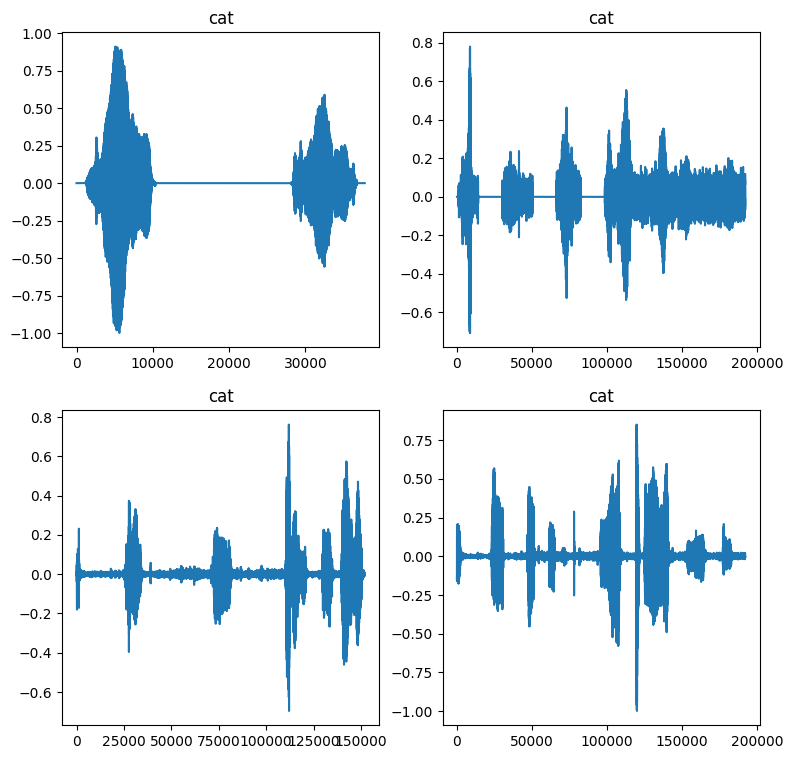

In [358]:
# number of rows and columns of plot
row,col = 2, 2
n = row*col
fig, axs = plt.subplots(row, col, figsize=(9, 9))

# plotting waveforms
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // col
  c = i % col
  ax = axs[r][c]
  ax.plot(audio.numpy())

  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

## construct spectrogram

In [359]:
# get all the labels from the dataset   
labels = np.array(["cat","dog"])

In [360]:
# function to get the spectogram and the labels
def get_spectrogram_label(audio, label):
  # apply padding
  padding = tf.zeros([300000] - tf.shape(audio), dtype=tf.float32)
  # get the spectogram of the audio
  wave = tf.cast(audio, tf.float32)
  eq_length = tf.concat([wave, padding], 0)
  spectrogram = tf.signal.stft(
      eq_length, frame_length=210, frame_step=110)    
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.expand_dims(spectrogram, -1)
  # get associated label of the audio
  label_id = tf.argmax(label == labels)
  # return the spectogram and the label
  return spectrogram, label_id

In [361]:
# get the labels and spectogram
spectrogram_ds = waveform_ds.map(
    get_spectrogram_label, num_parallel_calls=AUTO)

In [362]:
# function to plot the spectogram
def plot_spect(spectrogram, ax):
  # Converting frequencies to log and transpose to repesent time on x axis
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

/tmp/ipykernel_1111/3290999602.py:4: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)


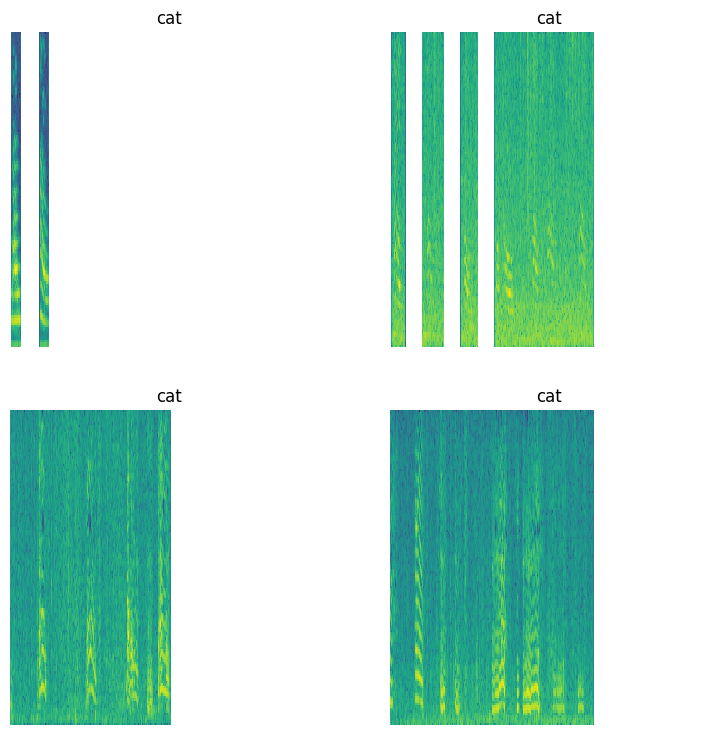

In [363]:
# plot using a subplot
rows = 2
cols = 2
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(9, 9))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  # function call
  plot_spect(np.squeeze(spectrogram.numpy()), ax)
  # set the title label
  ax.set_title(labels[label_id.numpy()])
  ax.axis('off')
plt.show()

## Let's preprocess the test file as well


In [364]:
# function to preprocess the data
def preprocess(file):
  files_ds = tf.data.Dataset.from_tensor_slices(file)
  # get waveforms and labels
  output_ds = files_ds.map(get_waveform_label, num_parallel_calls=AUTO)
  # get spectogram and labels
  output_ds = output_ds.map(
      get_spectrogram_label,  num_parallel_calls=AUTO)
 # return the data
  return output_ds

In [365]:
# train test and validate data
train_ds = spectrogram_ds

test_ds = preprocess(test_ds)

## Built the model

In [366]:
# initialize a batch size
batch_size = 64
# batch train and validate data
train_ds = train_ds.batch(batch_size)
# cache and prefetch the data
train_ds = train_ds.cache().prefetch(AUTO)

In [367]:
# building the model
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(labels)
# normalize adapt 
norm_layer = Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

# adding layers
model = models.Sequential([
    layers.Input(shape=input_shape),
    Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='softmax'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (2726, 129, 1)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ resizing_10 (Resizing)          │ (None, 32, 32, 1)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ normalization_10                │ (None, 32, 32, 1)         │          3 │
│ (Normalization)                 │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_80 (Conv2D)              │ (None, 30, 30, 32)        │        320 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_81 (Conv2D)              │ (None, 28, 28, 32)        │      9,248 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_82 (Conv2D)              │ (None, 26, 26, 32)        │      9,248 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_83 (Conv2D)              │ (None, 24, 24, 32)        │      9,248 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_84 (Conv2D)              │ (None, 22, 22, 32)        │      9,248 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_85 (Conv2D)              │ (None, 20, 20, 32)        │      9,248 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_86 (Conv2D)              │ (None, 18, 18, 32)        │      9,248 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_87 (Conv2D)              │ (None, 16, 16, 64)        │     18,496 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 8, 8, 64)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_20 (Dropout)            │ (None, 8, 8, 64)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_10 (Flatten)            │ (None, 4096)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_20 (Dense)                │ (None, 128)               │    524,416 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_21 (Dropout)            │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_21 (Dense)                │ (None, 2)                 │        258 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 598,981 (2.28 MB)

 Trainable params: 598,978 (2.28 MB)

 Non-trainable params: 3 (16.00 B)

In [368]:
model.compile(
    optimizer=tf.keras.optimizers.Adadelta(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [369]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 129, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [370]:
EPOCHS = 10
history = model.fit(
    train_ds,  
    epochs=EPOCHS,
    validation_data=test_ds.batch(batch_size)
)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.4951 - loss: 0.6937 - val_accuracy: 0.0000e+00 - val_loss: 0.7093
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5010 - loss: 0.6933 - val_accuracy: 0.0000e+00 - val_loss: 0.7093
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5108 - loss: 0.6918 - val_accuracy: 0.0000e+00 - val_loss: 0.7093
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5059 - loss: 0.6938 - val_accuracy: 0.0000e+00 - val_loss: 0.7093
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5098 - loss: 0.6934 - val_accuracy: 0.0000e+00 - val_loss: 0.7093
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5000 - loss: 0.6940 - val_accuracy: 0.0000e+00 - val_loss: 0.7093
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5127 - loss: 0.6925 - val_accuracy: 0.0000e+00 - val_loss: 0.7093
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5098 - loss: 0.6933 - val_accuracy: 

In [371]:
# initialize empty list to save the audio and labels
t_audio = []
t_labels = []

# load in the labels and audio from test dataset
for audio, label in test_ds:
  t_audio.append(audio.numpy())
  t_labels.append(label.numpy())

# convert the lists to a numpy array
t_audio = np.array(t_audio)
t_labels = np.array(t_labels)

In [372]:
# Feed in the data for prediction
y_pred = np.argmax(model.predict(t_audio), axis=1)

# store the original labels for testing the accuracy
y_true = t_labels

# get the testing accuracy
test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Test set accuracy: 0%


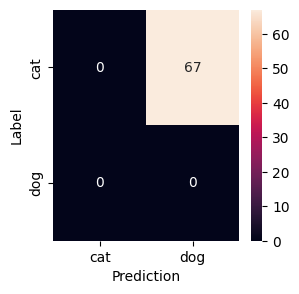

In [373]:
conf_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(3,3))
seaborn.heatmap(conf_mtx, xticklabels=labels, yticklabels=labels, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [374]:
confusion_matrix(y_true,y_pred)

array([[ 0, 67],
       [ 0,  0]])

In [375]:
accuracy_score(y_true,y_pred)

0.0

In [376]:
# Print the classification report
print(classification_report(y_true, y_pred, target_names=labels))

              precision    recall  f1-score   support

         cat       0.00      0.00      0.00      67.0
         dog       0.00      0.00      0.00       0.0

    accuracy                           0.00      67.0
   macro avg       0.00      0.00      0.00      67.0
weighted avg       0.00      0.00      0.00      67.0



/home/joachim/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/joachim/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/joachim/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/joachim/.local/lib/python3.10/site-p

/home/joachim/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


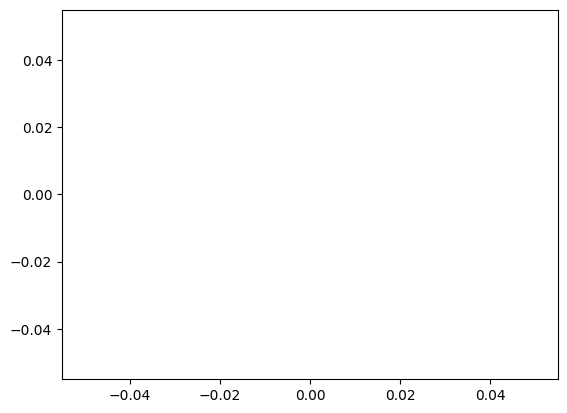

In [377]:
# Plot roc curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
plt.plot(fpr, tpr, linewidth=2)